# Fitting Thomson Scattering Spectra

[spectral_density]: ../../api/plasmapy.diagnostics.thomson.spectral_density.rst#plasmapy.diagnostics.thomson.spectral_density
[lmfit]: https://lmfit.github.io/lmfit-py/

Thomson scattering diagnostics record a scattered power spectrum that encodes information about the electron and ion density, temperatures, and flow velocities. This information can be retreived by fitting the measured spectrum with the theoretical spectral density ([spectral_density]). This notebook demonstrates how to use the [lmfit] package (along with some helpful PlasmaPy functions) to fit 1D Thomson scattering spectra. 

<img src="collective_vs_noncollective_ots.png">

Thomson scattering can be either non-collective (dominated by single electron scattering) or collective (dominated by scattering off of electron plasma waves (EPW) and ion acoustic waves (IAW). In the non-collective regime, the scattering spectrum contains a single peak. However, in the collective regime the spectrum contains separate features caused by the electron and ion populations (corresponding to separate scattering off of EPW and IAW). These features exist on different scales: the EPW feature is dim but covers a wide wavelength range, while the IAW feature is bright but narrow. They also encode partially-degenerate information (eg. the flow velocities of the electrons and ions respectively). The two features are therefore often recorded on separate spectrometers and are fit separately. 


In [37]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import warnings

from lmfit import Parameters

from plasmapy.diagnostics import thomson

## Contents

1. [Fitting Collective Thomson Scattering](#Fitting-Collective-Thomson-Scattering)
    1. [Fitting the EPW Feature](#Fitting-the-EPW-Feature)
    2. [Fitting the IAW Feature](#Fitting-the-IAW-Feature)
2. [Fitting Non-Collective Thomson Scattering](#Fitting-Non-Collective-Thomson-Scattering)

## Fitting Collective Thomson Scattering

[spectral_density]: ../../api/plasmapy.diagnostics.thomson.spectral_density.rst#plasmapy.diagnostics.thomson.spectral_density

To demonstrate the fitting capabilities, we'll first generate some synthetic Thomson data using the [spectral_density] function. This data will be in the collective regime, so we will generate two datasets (using the same plasma parameters and probe geometry) that correspond to the EPW and IAW features. For more details on the spectral density function, see the spectral density function example notebook.

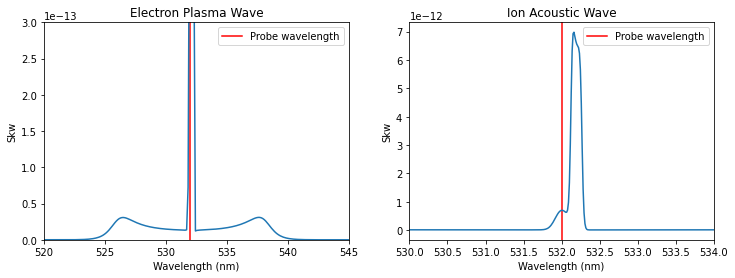

In [38]:
# Generate theoretical spectrum
probe_wavelength = 532 * u.nm
epw_wavelengths = (
    np.linspace(probe_wavelength.value - 30, probe_wavelength.value + 30, num=500)
    * u.nm
)
iaw_wavelengths = (
    np.linspace(probe_wavelength.value - 3, probe_wavelength.value + 3, num=500) * u.nm
)

probe_vec = np.array([1, 0, 0])
scattering_angle = np.deg2rad(63)
scatter_vec = np.array([np.cos(scattering_angle), np.sin(scattering_angle), 0])

n = 2e17 * u.cm ** -3
ion_species = ["H+", "C-12 5+"]
Te = 10 * u.eV
Ti = np.array([20, 50]) * u.eV
electron_vel = np.array([[0, 0, 0]]) * u.km / u.s
ion_vel = np.array([[0, 0, 0], [200, 0, 0]]) * u.km / u.s
ifract = [0.3, 0.7]

alpha, epw_skw = thomson.spectral_density(
    epw_wavelengths,
    probe_wavelength,
    n,
    Te,
    Ti,
    ion_species=ion_species,
    ifract=ifract,
    electron_vel=electron_vel,
    ion_vel=ion_vel,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)

alpha, iaw_skw = thomson.spectral_density(
    iaw_wavelengths,
    probe_wavelength,
    n,
    Te,
    Ti,
    ion_species=ion_species,
    ifract=ifract,
    electron_vel=electron_vel,
    ion_vel=ion_vel,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)

# PLOTTING
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax[0].set_xlim(520, 545)
ax[0].set_ylim(0, 3e-13)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(530, 534)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend();

Note that these plots are showing the same spectral distribution, just over different wavelength ranges: the large peak in the center of the EPW spectrum is the IAW spectrum. Next we'll add some noise to the spectra to simulate an experimental measurement.

In [39]:
epw_skw *= 1 + np.random.normal(loc=0, scale=0.1, size=epw_wavelengths.size)

iaw_skw *= 1 + np.random.normal(loc=0, scale=0.1, size=iaw_wavelengths.size)

[np.nan]: https://numpy.org/doc/stable/reference/constants.html#numpy.NAN
During experiments, the IAW feature is typically blocked on the EPW detector using a notch filter to prevent it from saturating the measurement. We'll mimic this by setting the center of the EPW spectrum to [np.nan]. The fitting algorithm applied later will recognize these values and not include them in the fit.

The more of the EPW spectrum we exclude, the less sensitive the fit will become. So, we want to block as little as possible while still obscuring the IAW feature.

In [40]:
notch_range = (531, 533)
x0 = np.argmin(np.abs(epw_wavelengths.value - notch_range[0]))
x1 = np.argmin(np.abs(epw_wavelengths.value - notch_range[1]))
epw_skw[x0:x1] = np.nan

[np.nanmax()]: https://numpy.org/doc/stable/reference/generated/numpy.nanmax.html
Finally, we need to get rid of the units and normalize the data on each detector to its maximum value (this is a requirement of the fitting algorithm). We're using [np.nanmax()] here to ignore the NaN values in `epw_skw`.

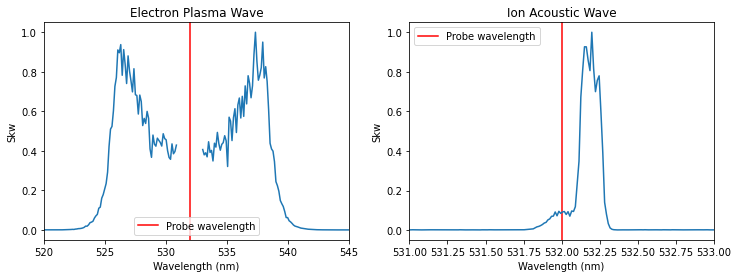

In [41]:
epw_skw = epw_skw.value
epw_skw *= 1 / np.nanmax(epw_skw)
iaw_skw = iaw_skw.value
iaw_skw *= 1 / np.nanmax(iaw_skw)

# Plot again
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax[0].set_xlim(520, 545)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(531, 533)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend()

We'll start by fitting the EPW feature, then move on to the IAW feature. This is typically the process followed when analyzing experimental data, since the EPW feature depends on fewer parameters.

### Fitting the EPW Feature

[spectral_density]: ../../api/plasmapy.diagnostics.thomson.spectral_density.rst#plasmapy.diagnostics.thomson.spectral_density
[lmfit]: https://lmfit.github.io/lmfit-py/
[lmfit.Parameter]: https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter
[lmfit.Parameters]: https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters
[lmfit.Model]:https://lmfit-py.readthedocs.io/en/0.9.12/model.html#the-model-class
[spectral_density_model]: ../../api/plasmapy.diagnostics.thomson.spectral_density_model.rst#plasmapy.diagnostics.thomson.spectral_density_model

In order to fit this data in [lmfit] we need to create an [lmfit.Model] object for this problem. PlasmaPy includes such a model function for fitting Thomson scattering spectra, [spectral_density_model]. This model function is intialized by providing the parameters of the fit in the form of an [lmfit.Parameters] object.

A [lmfit.Parameters] object is an ordered dictionary of [lmfit.Parameter] objects. Each [lmfit.Parameter] has a number of elements, the most important of which for our purposes are
- "name" (str) -> The name of the parameter (and the key in `Parameters` dictionary)
- "value" (float) -> The initial value of the parameter.
- "vary" (boolean) -> Whether or not the parameter will be varied during fitting.
- "min", "max" (float) -> The minimum and maximum bounds for the parameter during fitting.

Since [lmfit.Parameter] objects can only be scalars, arrays of multiple quantities must be broken apart into separate `Parameter` objects. To do so, this fitting routine adopts the following convention:

`Te = [1,2] -> "Te_0"=1, "Te_1" = 2`

Specifying large arrays (like velocity vectors for multiple ion species) is clearly tedious in this format, and specifying non-numeric values (such as `ion_species`) is impossible. Therefore, this routine also takes a `settings` dictionary as a way to pass non-varying input to the [spectral_density_model] function.

A list of required and optional parameters and settings is provided in the docstring for the [spectral_density_model] function. For example:

In [42]:
help(thomson.spectral_density_model)

Help on function spectral_density_model in module plasmapy.diagnostics.thomson:

spectral_density_model(wavelengths, settings, params)
    Returns a `lmfit.Model` function for Thomson spectral density function
    
    
    Parameters
    ----------
    
    
    wavelengths : np.ndarray
        Wavelength array, in meters.
    
    
    settings : dict
        A dictionary of non-variable inputs to the spectral density function
        which must include the following:
    
            - probe_wavelength: Probe wavelength in meters
            - probe_vec : (3,) unit vector in the probe direction
            - scatter_vec: (3,) unit vector in the scattering direction
            - ion_species : list of Particle strings describing each ion species
    
        and may contain the following optional variables
            - electron_vdir : (e#, 3) array of electron velocity unit vectors
            - ion_vdir : (e#, 3) array of ion velocity unit vectors
            - inst_fcn : A functio

[lmfit.Parameters]: https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters
[spectral_density]: ../../api/plasmapy.diagnostics.thomson.spectral_density.rst#plasmapy.diagnostics.thomson.spectral_density

We will now create the [lmfit.Parameters] object and settings dictionary using the values defined earlier when creating the sample data. We will choose to vary both the density and electron temperature, and will intentionally set incorrect initial values for both parameters. Note that, even though only one electron population is inclued, we must still name the temperature variable `Te_0` in accordance with the convention defined above.

Note that the EPW spectrum is effectively independent of the ion parameters: only `n`, `Te`, and `electron_vel` will affect this fit. However, since the ion parameters are required arguments for [spectral_density], we still need to provide values for them. We will therefore set these parameters as fixed (`vary=False`) with approximate values (in this case, intentionally poor estimates have been chosen to emphasize that they do not affect the EPW fit). 

In [43]:
params = Parameters()
params.add(
    "n", value=4e17 * 1e6, vary=True, min=5e16 * 1e6, max=1e18 * 1e6
)  # Converting cm^-3 to m^-3
params.add("Te_0", value=5, vary=True, min=0.5, max=25)
params.add("Ti_0", value=5, vary=False)
params.add("Ti_1", value=10, vary=False)
params.add("ifract_0", value=0.8, vary=False)
params.add("ifract_1", value=0.2, vary=False)
params.add("ion_speed_0", value=0, vary=False)
params.add("ion_speed_1", value=0, vary=False)

settings = {}
settings["probe_wavelength"] = probe_wavelength.to(u.m).value
settings["probe_vec"] = probe_vec
settings["scatter_vec"] = scatter_vec
settings["ion_species"] = ion_species
settings["ion_vdir"] = np.array([[1, 0, 0], [1, 0, 0]])

[spectral_density]: ../../api/plasmapy.diagnostics.thomson.spectral_density.rst#plasmapy.diagnostics.thomson.spectral_density
[lmfit]: https://lmfit.github.io/lmfit-py/
[spectral_density_model]: ../../api/plasmapy.diagnostics.thomson.spectral_density_model.rst#plasmapy.diagnostics.thomson.spectral_density_model
[constraint]: https://lmfit.github.io/lmfit-py/constraints.html
[lmfit.Parameter]: https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter
[lmfit.Model]:https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model

[lmfit] allows the value of a parameter to be fixed using a [constraint] using the `expr` keyword in [lmfit.Parameter] as shown in the definition of `ifract_1` above. In this case, `ifract_1` is not actually a free parameter, since its value is fixed by the fact that `ifract_0 + ifract_1 = 1.0`. This constraint is made explicit here, but the [spectral_density_model] function will automatically enforce this constraint for `efract` and `ifract` variables.

Just as in the [spectral_density] function, some parameters are required while others are optional. For example, density (`n`) is required but `ion_velocity` is optional (and will be assumed to be zero if not provided). The list of required and optional parameters is identical to the required and optional arguments of [spectral_density].

We can now use these objects to initialize an [lmfit.Model] object based on the [spectral_density] function using the [spectral_density_model] function.

In [44]:
epw_model = thomson.spectral_density_model(
    epw_wavelengths.to(u.m).value, settings, params
)

[model.fit()]: https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model.fit
[minimizer options]: https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.minimize
[np.ndarray]:https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html

With the model created, the fit can be easily performed using the [model.fit()] method. This method takes several keyword options that are worth mentioning: 

- "method" -> A string that defines the fitting method, from the list of [minimizer options]. A good choice for fitting Thomson spectra is `differential_evolution`.

- "max_nfev" -> The maximum number of iterations allowed.

In addition, of course we also need to include the data to be fit (`epw_skw`), the independent variable (`wavelengths`) and the parameter object. It is important to note that the data to be fit should be a [np.ndarray] (unit-less) and normalized.

In [45]:
fit_kws = {}
epw_result = epw_model.fit(
    epw_skw,
    params=params,
    wavelengths=epw_wavelengths.to(u.m).value,
    method="differential_evolution",
    fit_kws=fit_kws,
)

[model.fit()]: https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model.fit
[scipy.optimize]: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
[differential_evolution]:https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
[lmfit.ModelResult]:https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult

In the [model.fit()], the `fit_kws` keyword can be set to a dictionary of keyword arguments that will be passed to the underlying [scipy.optimize] optimization function, and can be used to refine the fit. For details, see the SciPy documentation for the [differential_evolution] algorithm. 

The return from this function is a [lmfit.ModelResult] object, which is a convenient container holding lots of information! To start with, we can see the best-fit parameters, number of iterations, the chiSquared goodness-of-fit metric, and plot the best-fit curve.

In [46]:
# Print some of the results compared to the true values
answers = {"n": 2e17, "Te_0": 10}
for key, ans in answers.items():
    print(f"{key}: {epw_result.best_values[key]:.1e} (true value {ans:.1e})")

print(f"Number of fit iterations:{epw_result.nfev}")
print(f"Reduced Chisquared:{epw_result.redchi:.4f}")

# Extract the best fit curve by evaluating the model at the final parameters
n_fit = epw_result.values["n"]
Te_0_fit = epw_result.values["Te_0"]

n: 2.1e+23 (true value 2.0e+17)
Te_0: 9.2e+00 (true value 1.0e+01)
Number of fit iterations:561
Reduced Chisquared:0.0011


Note that the best_fit curve skips the NaN values in the data, so the array is shorter than `epw_skw`. In order to plot them against the same wavelengths, we need to create an array of indices where `epw_skw` is not NaN.

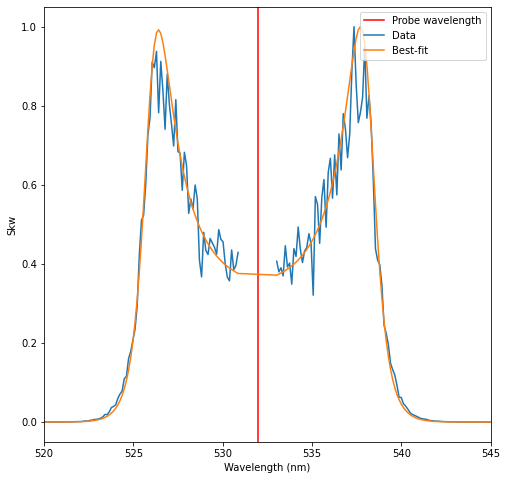

In [47]:
# Extract the best fit curve
best_fit_skw = epw_result.best_fit

# Get all the non-nan indices (the best_fit_skw just omits these values)
not_nan = np.argwhere(np.logical_not(np.isnan(epw_skw)))

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax.set_xlim(520, 545)

ax.plot(epw_wavelengths.value, epw_skw, label="Data")
ax.plot(epw_wavelengths.value[not_nan], best_fit_skw, label="Best-fit")
ax.legend(loc="upper right");

The resulting fit is very good, even though many of the ion parameters are still pretty far from their actual values!

## Fitting the IAW Feature

[lmfit.Parameters]: https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters

We will now follow the same steps to fit the IAW feature. We'll start by setting up a new [lmfit.Parameters] object, this time using the best-fit values from the EPW fit as fixed values for those parameters.

In [48]:
settings = {}
settings["probe_wavelength"] = probe_wavelength.to(u.m).value
settings["probe_vec"] = probe_vec
settings["scatter_vec"] = scatter_vec
settings["ion_species"] = ion_species
settings["ion_vdir"] = np.array([[1, 0, 0], [1, 0, 0]])

params = Parameters()
params.add("n", value=n_fit, vary=False)
params.add("Te_0", value=Te_0_fit, vary=False)
params.add("Ti_0", value=10, vary=True, min=5, max=60)
params.add("Ti_1", value=10, vary=True, min=5, max=60)
params.add("ifract_0", value=0.5, vary=True, min=0.2, max=0.8)
params.add("ifract_1", value=0.5, vary=True, min=0.2, max=0.8, expr="1.0 - ifract_0")
params.add("ion_speed_0", value=0, vary=False)
params.add("ion_speed_1", value=0, vary=True, min=0, max=1e6)

Now we wil run the fit

In [49]:
iaw_model = thomson.spectral_density_model(
    iaw_wavelengths.to(u.m).value, settings, params
)

iaw_result = iaw_model.fit(
    iaw_skw,
    params=params,
    wavelengths=iaw_wavelengths.to(u.m).value,
    method="differential_evolution",
)

# Print some of the results compared to the true values
answers = {"Ti_0": 20, "Ti_1": 50, "ifract_0": 0.3, "ifract_1": 0.7, "ion_speed_1": 2e5}
for key, ans in answers.items():
    print(f"{key}: {iaw_result.best_values[key]:.1f} (true value {ans:.1f})")

print(f"Number of fit iterations:{iaw_result.nfev:.1f}")
print(f"Reduced Chisquared:{iaw_result.redchi:.4f}")

Ti_0: 23.9 (true value 20.0)
Ti_1: 41.1 (true value 50.0)
ifract_0: 0.3 (true value 0.3)
ifract_1: 0.7 (true value 0.7)
ion_speed_1: 199561.6 (true value 200000.0)
Number of fit iterations:1440.0
Reduced Chisquared:0.0003


And plot the results

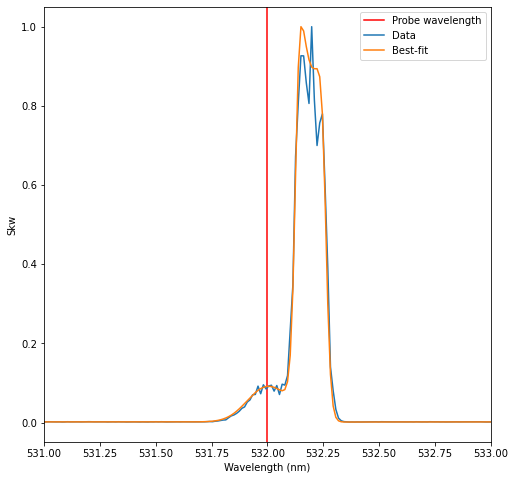

In [50]:
# Extract the best fit curve
best_fit_skw = iaw_result.best_fit

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax.set_xlim(531, 533)

ax.plot(iaw_wavelengths.value, iaw_skw, label="Data")
ax.plot(iaw_wavelengths.value, best_fit_skw, label="Best-fit")
ax.legend(loc="upper right");

At this point, the best-fit parameters from the IAW fit could be used to further refine the EPW fit, and so on iteratively until both fits become stable.

## Fitting Non-Collective Thomson Scattering

The non-collective Thomson scattering spectrum depends only on the electron density and temperature. In this regime the spectrum is less featured and, consequently, fits will produce larger errors. Otherwise, the fitting procedure is the same. 

To illustrate fitting in this regime, we'll start by generating some test data

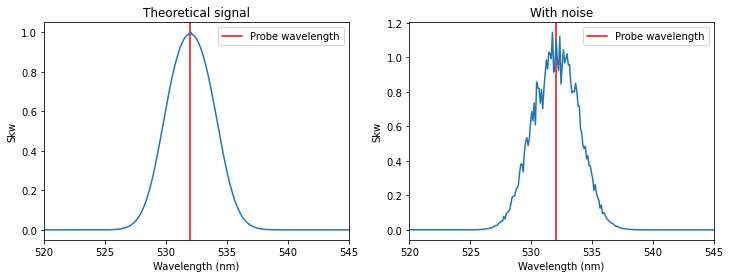

In [51]:
nc_wavelengths = (
    np.linspace(probe_wavelength.value - 50, probe_wavelength.value + 50, num=1000)
    * u.nm
)

n = 5e15 * u.cm ** -3
Te = 5 * u.eV
Ti = np.array([1]) * u.eV
ion_species = ["H+"]

alpha, Skw = thomson.spectral_density(
    nc_wavelengths,
    probe_wavelength,
    n,
    Te,
    Ti,
    ion_species=ion_species,
    probe_vec=probe_vec,
    scatter_vec=scatter_vec,
)

# Normalize and add noise
nc_skw = Skw.value
nc_skw *= 1 / np.nanmax(nc_skw)
nc_theory = np.copy(nc_skw)
nc_skw *= 1 + np.random.normal(loc=0, scale=0.1, size=nc_wavelengths.size)


# Plot again
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax[0].set_xlim(520, 545)
ax[0].set_title("Theoretical signal")
ax[0].plot(nc_wavelengths.value, nc_theory)
ax[0].legend()

ax[1].set_xlim(520, 545)
ax[1].set_title("With noise")
ax[1].plot(nc_wavelengths.value, nc_skw)
ax[1].legend()

[lmfit.Parameters]: https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters
[spectral_density]: ../../api/plasmapy.diagnostics.thomson.spectral_density.rst#plasmapy.diagnostics.thomson.spectral_density
Then we will setup the settings dictionary and [lmfit.Parameters] object and run the fit.


Note that, in the non-collective regime, the [spectral_density] function is effectively independent of density. Just as in the [collective-regime EPW fitting](###-Fitting-the-EPW-Feature) section, we still need to provide a value for `n` because it is a required argument for [spectral_density], but this parameter should be fixed and its value can be a rough approximation.

In [52]:
settings = {}
settings["probe_wavelength"] = probe_wavelength.to(u.m).value
settings["probe_vec"] = probe_vec
settings["scatter_vec"] = scatter_vec
settings["ion_species"] = ion_species

params = Parameters()
params.add("n", value=1e15 * 1e6, vary=False)  # Converting cm^-3 to m^-3
params.add("Te_0", value=1, vary=True, min=0.1, max=20)
params.add("Ti_0", value=1, vary=False)

nc_model = thomson.spectral_density_model(
    nc_wavelengths.to(u.m).value, settings, params
)

nc_result = nc_model.fit(
    nc_skw,
    params,
    wavelengths=nc_wavelengths.to(u.m).value,
    method="differential_evolution",
)

Te_0: 6.1 (true value 5)
Number of fit iterations:98
Reduced Chisquared:0.0003


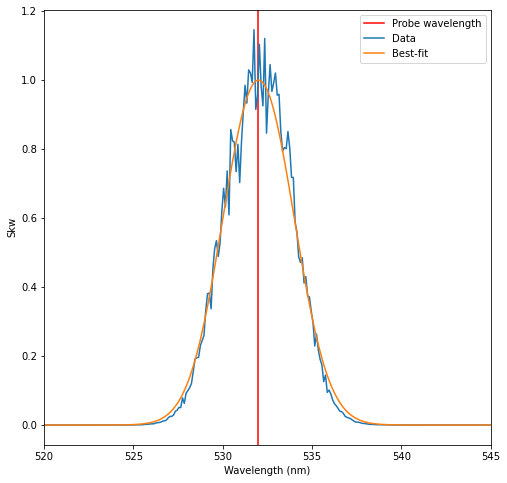

In [53]:
best_fit_skw = nc_result.best_fit

print(f"Te_0: {nc_result.best_values['Te_0']:.1f} (true value 5)")
print(f"Number of fit iterations:{nc_result.nfev}")
print(f"Reduced Chisquared:{nc_result.redchi:.4f}")

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color="red", label="Probe wavelength")

ax.set_xlim(520, 545)

ax.plot(nc_wavelengths.value, nc_skw, label="Data")
ax.plot(nc_wavelengths.value, best_fit_skw, label="Best-fit")
ax.legend(loc="upper right");